In [1]:
#Load Packages
import cmasher           as cmr
import cartopy.crs       as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy             as np
import os
import pandas            as pd 
import regionmask        as rm
import warnings
import xarray            as xr
print("Packages Loaded")

Packages Loaded


143   -0.317
328    1.404
329    0.492
333    0.529
770   -2.562
771   -0.128
950   -0.523
951    0.771
986   -0.814
dtype: float64

In [2]:
#Set Working Directory
wd = '/Volumes/GoogleDrive/My Drive/zResearch/Manuscript/2021_HoloceneHydroclimate/2021_HoloceneHydroclimate'
os.chdir(wd)
print('Working wirectory set to: '+wd)

Working wirectory set to: /Volumes/GoogleDrive/My Drive/zResearch/Manuscript/2021_HoloceneHydroclimate/2021_HoloceneHydroclimate


In [3]:
#Load Model Data TraCE & HadCM
modelData = {}
for model in ['hadcm','trace','cmip6']:
    modelData[model] = {}
    for szn in ['ANN','JJA','DJF']:
        if model == 'cmip6': end = '.nc'
        else: end =  '_regrid.nc'
        modelData[model][szn] = xr.open_dataset('Data/Model/'+model+'/'+model+'_'+szn+end,decode_times=False)
    print(model+" "+str(sorted([i for i in modelData[model][szn].data_vars]))+' loaded')
    
#Define ipcc region data
refReg     = rm.defined_regions.ar6.all
refRegLand = rm.defined_regions.ar6.land

hadcm ['evp_regrid', 'p-e_regrid', 'pre_regrid', 'tas_regrid'] loaded
trace ['evp_regrid', 'p-e_regrid', 'pre_regrid', 'tas_regrid'] loaded
cmip6 ['evp', 'p-e', 'pre', 'tas'] loaded


In [11]:
#Plot Agreement Settings

#Model Data to Plot
szn       = 'ANN'
variables = ['pre','tas']

#Proxy Settings
n_thresh = 4 #minimum number of proxy records needed to plot on map

#True/False to save/not save
save = True 

#Plot Settings
plt.rcParams['font.family'   ] = 'Times New Roman'
plt.rcParams['axes.facecolor'] ='white'
plt.rcParams['axes.linewidth'] = 0.8; 
plt.rcParams['axes.edgecolor'] = 'k'

figSize = [6.5,4] # x,y in
orient = 'h' #vertical (v) or horizontal (h)

#Print summary
if save: print("Settings chosen to save "+szn+" "+str(variables))
else:    print("Settings chosen to plot "+szn+" "+str(variables))

Settings chosen to save ANN ['pre', 'tas']


In [12]:
#Calculate Model Percents
modelVals = {}
for season in ['ANN','DJF','JJA']:
    modelVals[season] = {}
    for var in variables:
        modelVals[season][var]= {}
        modelAnom     = modelData['cmip6'][season][var]
        for model in ['hadcm','trace']:       
            vals = modelData[model][season]
            vals = vals.rename({var+'_regrid':var})
            vals = vals[var].groupby_bins('age',[0,1000,5500,6500]).mean(dim="age")
            vals = vals[2,:,:]-vals[0,:,:]
            vals = vals.expand_dims("model").assign_coords(model=("model", [model]))
            modelAnom = xr.concat([modelAnom,  vals], dim="model")
        modelVals[season][var]['modelAnom']  = modelAnom
        modelN = len(modelVals[season][var]['modelAnom'].model)
        modelVals[season][var]['modelSign']  = np.sum(np.sign(modelAnom),axis=0) 
        modelVals[season][var]['modelSign%'] = 100*(modelVals[season][var]['modelSign']/modelN)

In [14]:
#Calculate Proxy Percents
proxyData = {}
for var in variables:
    if var == 'tas': proxy = pd.read_csv('Data/proxy/proxyMetaData_T.csv')
    else:            proxy = pd.read_csv('Data/proxy/proxyMetaData_HC.csv')
    proxy=proxy.loc[proxy.season.str.lower().isin(['annual','summer','winter','summeronly','winteronly','summerOnly; winterOnly',np.nan])] 
    Regs, Pcts, PseudoPct, PseduoAvg, n, lats, lons, agreeByProxylocation = [],[],[],[],[],[],[],[]
    for reg in np.unique(proxy['ipccReg']): 
        #Filter proxy data for region
        regData = proxy.loc[proxy['ipccReg'] == reg] 
        if np.shape(regData)[0] < 4: continue
        #Calculate midHolocene anomalies
        direction = 2*((regData['direction'] != 'negative')-0.5)
        regData2 = (regData['ka_6']-regData['ka_0.5'])*direction
        regData2 = regData2[regData2.notnull()]
        #regData2 = regData2[regData2 != 0]
        if sum(~np.isnan(regData2)) < 4: continue
        #Calculate pseudoproxy
        pseudoVal = []
        pseudoVal2=[]
        agreeByLoc=[]
        #for prox in (regData['ka_6']-regData['ka_0.5']).index:
        for prox in regData2.index:
            proxyLon = regData.longitude[prox]
            proxyLat = regData.latitude[prox]
            if proxyLon < 0: proxyLon = 360 + proxyLon
            #
            proxySzn = str(regData.season[prox])
            if proxyLat < 0:
                if    proxySzn[:3].lower() == 'sum': proxySzn='DJF'
                elif  proxySzn[:3].lower() == 'win': proxySzn='JJA'
                else: proxySzn = 'ANN'
            else:
                if    proxySzn[:3].lower() == 'sum': proxySzn='JJA'
                elif  proxySzn[:3].lower() == 'win': proxySzn='DJF'
                else: proxySzn = 'ANN'
            #
            if var =='tas': 
                proxyVar = 'tas'
            elif regData.climInterp[prox] == 'P': 
                proxyVar = 'pre'
            else: proxyVar = 'pre'
            proxyVar 
            proxyLat = np.argmin(abs(modelVals[proxySzn][var]['modelAnom'].lat.data-proxyLat))
            proxyLon = np.argmin(abs(modelVals[proxySzn][var]['modelAnom'].lon.data-proxyLon))
            addVals = modelVals[proxySzn][proxyVar]['modelAnom'][:,proxyLat,proxyLon].data.tolist()
            pseudoVal.append(addVals)
            agreeByLoc.append(np.sum(np.sign(regData2[prox]) * np.sign(addVals) == 1)/len(np.sign(regData2[prox]) * np.sign(addVals) == 1))
            if var == 'tas':
                pseudoVal2.append(addVals)
            elif regData.archive[prox].lower()[:3] != 'mar':
                pseudoVal2.append(addVals)
        pseudoVal = [i for x in pseudoVal for i in x]
        pseudoVal2 = [i for x in pseudoVal2 for i in x]
        #Save region data
        PseduoAvg.append(np.mean(pseudoVal2))
        PseudoPct.append(100*sum(i > 0 for i in pseudoVal)/len(pseudoVal))
        Regs.append(reg)
        agreeByProxylocation.append(np.mean(agreeByLoc))
        Pcts.append(100*(sum(regData2>0)/(sum(regData2!=0))))
        lats.append(refReg.centroids[refReg.abbrevs.index(reg)][1])
        lons.append(refReg.centroids[refReg.abbrevs.index(reg)][0])
        n.append(sum(~np.isnan(regData2)))
    proxyData[var] = pd.DataFrame({'lat':lats,'lon':lons,'region':Regs,'n':n,
                                   'proxyPct':Pcts,'PseudoProxyAvg':PseduoAvg,'PseudoProxyPct':PseudoPct,'agreeByLoc':agreeByProxylocation})
    print("--------------------------------------------------------------------------------")
    print("Percent of "+str(var).upper()+" records showing a positive mid-Holocene anomaly")
    print(proxyData[var].sort_values('agreeByLoc',ascending=False))
    print("--------------------------------------------------------------------------------")

--------------------------------------------------------------------------------
Percent of PRE records showing a positive mid-Holocene anomaly
          lat         lon region   n    proxyPct  PseudoProxyAvg  \
16  22.148393    8.834955    SAH   8  100.000000        0.156353   
17 -13.757333  -60.488533    SAM   5    0.000000       -0.412658   
10   8.501081   39.169917   NEAF  11  100.000000        0.402804   
4  -20.557576   32.603030   ESAF   6   16.666667       -0.279613   
14  -2.638466  -77.050921    NWS   7   14.285714       -0.485897   
24  32.425926   87.537037    TIB  20   80.000000        0.409563   
28 -23.000000   16.500000   WSAF   6   66.666667       -0.059591   
1   32.570597  121.983988    EAS  37   89.189189        0.185593   
0   39.543366  -96.966019    CNA  25   10.000000       -0.104095   
13  63.942315 -132.588290    NWN  41   37.500000       -0.011915   
3   39.759336  -76.593361    ENA  78   22.077922       -0.058579   
11  64.448399  -81.895070    NEN  15   2

'T'

Precipitation (18/30 agree; 2/30 disagree)
Temperature (10/35 agree; 20/35 disagree)


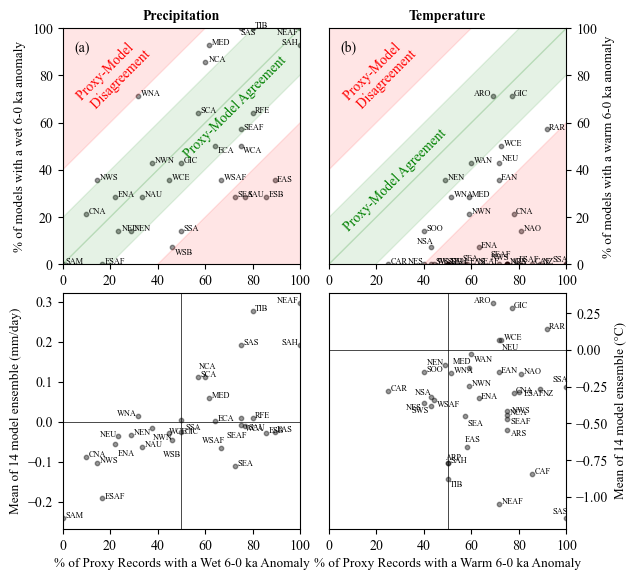

In [20]:
#Plot the figure 8
import matplotlib.patches as patches
import matplotlib.lines as lines
font='times new roman'
fontsize=9.5
fig = plt.figure(figsize=(6.5, 6.5))
pseudo_x=False
pseudo_y=False
for var in ['pre','tas']:
    if var == 'tas': 
        varName='Temperature'
        cramp='RdBu_r'
        ax1 = fig.add_subplot(222)
        ax1.set_ylabel("% of models with a warm 6-0 ka anomaly",size=fontsize)
        if    pseudo_y: ax1.set_ylabel("% Warm",size=fontsize)
        else:           ax1.set_ylabel("% of models with a warm 6-0 ka anomaly",size=fontsize)
        #ax1.set_xlabel("% of proxy records with a warm mid-Holocene anomaly",size=fontsize)
        ax1.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")
        ax2 = fig.add_subplot(224)
        ax2.set_ylabel("Mean of 14 model ensemble (degC)",size=fontsize)
        if    pseudo_y: ax2.set_ylabel("Temperature ("+u'\N{DEGREE SIGN}'+"C)",size=fontsize) ###
        else:           ax2.set_ylabel("Mean of 14 model ensemble ("+u'\N{DEGREE SIGN}'+"C)",size=fontsize)
        if    pseudo_x: ax2.set_xlabel("% of PSEUDOproxy records with a warm 6-0 ka anomaly",size=fontsize)
        else:           ax2.set_xlabel("% of Proxy Records with a Warm 6-0 ka Anomaly",size=fontsize) ###
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
    else: 
        varName='Precipitation'
        cramp='BrBG'
        ax1 = fig.add_subplot(221)
        if    pseudo_y: ax1.set_ylabel("Modeled Pseudoproxy 6-0 ka Anomalies \n % Wet",size=fontsize)
        else:           ax1.set_ylabel("% of models with a wet 6-0 ka anomaly",size=fontsize)
        #ax1.set_xlabel("% of proxy records with a wet mid-Holocene anomaly",size=fontsize)
        ax2 = fig.add_subplot(223)
        if    pseudo_y: ax2.set_ylabel("Modeled Pseudoproxy 6-0 ka Anomalies \n Precipitation Amount (mm/day)",size=fontsize)  ###
        else:           ax2.set_ylabel("Mean of 14 model ensemble (mm/day)",size=fontsize)
        if    pseudo_x: ax2.set_xlabel("% of PSEUDOproxy records with a wet 6-0 ka anomaly",size=fontsize)
        else:           ax2.set_xlabel("% of Proxy Records with a Wet 6-0 ka Anomaly",size=fontsize) ###

    #
    ### Top Row ------------------------------------------
    #Data to plot
    if    pseudo_x: x1    = proxyData[var].PseudoProxyPct
    else:           x1    = proxyData[var].proxyPct
    if    pseudo_y: y1    = proxyData[var].PseudoProxyPct
    else:           y1    = proxyData[var].modelPct
    text1 = proxyData[var].region
    #Add gridlines to aid visual
    #ax1.add_artist(lines.Line2D([0, 100], [0, 100],c='k',lw=0.5))
    for i in [0,40,60]:
        #ax.axhline(y = i)
        #ax.axvline(x = i)
        if i == 40: j =20
        else: j = 40
    #ax1.add_patch(patches.Rectangle((0, 60), 40, 40,color='red',alpha=0.1))
    #ax1.add_patch(patches.Rectangle((60, 0), 40, 40,color='red',alpha=0.1))
    #Set figure bound
    else: ax1.set_title(varName,size=10,weight='bold')
    ax1.set_xlim([0, 100])
    ax1.set_ylim([0, 100])
    #Plot Scatter
    ax1.scatter(x1, y1, c='k', alpha=0.4,s=10,vmin=0, vmax=100)
    #Loop for annotation of all points
    for i in range(len(x1)):
        xnudge = 1
        ynudge = 0
        if var != 'tas':
            if text1[i] == 'WSB': ynudge=-3
            elif text1[i] == 'EAS': ynudge=-1
            elif text1[i] == 'NEAF': xnudge,ynudge =-10,-3
            elif text1[i] == 'SAH': xnudge=-8
            #elif text1[i] == 'SEA': xnudge= -7
            elif text1[i] == 'ECA': ynudge= -3
            #elif text1[i] == 'NWS': xnudge=-9
            elif text1[i] == 'WCA': ynudge= -3
            elif text1[i] == 'SAS': xnudge,ynudge =0,-3
        else: 
            if text1[i] == 'ARO': xnudge=-8
            elif text1[i] == 'ARP': ynudge=-3
            elif text1[i] == 'NEU': ynudge=1
            elif text1[i] == 'SSA': xnudge,ynudge=-6,1
            elif text1[i] == 'SAS': xnudge,ynudge=-6,-3
            elif text1[i] == 'SAS': xnudge,ynudge=-6,-3
            elif text1[i] == 'NSA': xnudge,ynudge=-6,1.5
            elif text1[i] == 'NES': xnudge,ynudge=-7,0
            elif text1[i] == 'SEAF': xnudge,ynudge=-7,3
            elif text1[i] == 'NEAF': xnudge,ynudge=-9,0
            elif text1[i] == 'ARS': xnudge,ynudge=1.5,0
            elif text1[i] == 'NWS': xnudge,ynudge=-7,2
            elif text1[i] == 'SEA': ynudge,xnudge= 1.5,-1
            elif text1[i] == 'SWS': ynudge,xnudge= 0,2
            elif text1[i] == 'ESAF': ynudge,xnudge= 1,0
        ax1.annotate(text1[i], (x1[i]+xnudge, y1[i]+ynudge), size=6)
    #
    ### Bottom Row ------------------------------------------
    #Data to plot
    if    pseudo_x: x2    = proxyData[var].PseudoProxyPct
    else:           x2    = proxyData[var].proxyPct
    if    pseudo_y: y2    = proxyData[var].PseudoProxyAvg
    else:           y2    = proxyData[var].anom 
    text2 = proxyData[var].region
    #Add gridlines to aid visual
    #ax2.add_artist(lines.Line2D([0, 100], [0, 100],c='k',lw=0.5))
    ax2.axhline(y = 0,color='k',lw=0.5)
    ax2.axvline(x = 50,color='k',lw=0.5)
    #Set figure bound
    #if var == 'tas': 
        #ax2.set_ylim([-1, 1])
        #ax2.set_yticks([-0.9,-0.6,-0.3,0,0.3,0.6,0.9])
    #else:            
        #ax2.set_ylim([-0.4, 0.8])
    ax2.set_xlim([0, 100])
    ax1.set_ylim([0, 100])
    #Plot Scatter
    scatter = ax2.scatter(x2, y2, c='k', s=10, alpha=0.4,vmin=0, vmax=100)
    #Loop for annotation of all points
    for i in range(len(x2)):
        xnudge = 1
        ynudge = 0
        if var != 'tas':
            if text2[i] == 'WSB': ynudge,xnudge= -0.04,-4
            elif text2[i] == 'WNA': ynudge,xnudge=-0.0,-9
            elif text2[i] == 'NEU': xnudge=-8
            elif text2[i] == 'NEAF': xnudge=-10
            elif text2[i] == 'SAH': xnudge=-8
            #elif text2[i] == 'SAS': ynudge=-0.05
            elif text2[i] == 'ENA': ynudge,xnudge= -0.03,1
            elif text2[i] == 'NWN': ynudge,xnudge= -0.03,0
            #elif text2[i] == 'RFE': ynudge,xnudge= 0.02,-0
            #elif text2[i] == 'ECA': ynudge,xnudge= 0.02,-0
            elif text2[i] == 'SAU': ynudge,xnudge= -0.01,1.4
            elif text2[i] == 'WCA': ynudge,xnudge= -0.014,1.5
            elif text2[i] == 'NCA': ynudge,xnudge= 0.02,-3
            elif text2[i] == 'WCE': ynudge,xnudge= 0,0#-0.02,-2
            #elif text2[i] == 'SCA': ynudge,xnudge= 0.01,-7
            elif text2[i] == 'SSA': ynudge,xnudge= 0.005,1.5#-0.03,-12
            elif text2[i] == 'GIC': ynudge,xnudge= -0.035,1.5#-0.03,-12
            elif text2[i] == 'WSAF': ynudge,xnudge= 0.015,-8
            elif text2[i] == 'SEAF': ynudge,xnudge= -0.05,-6
        else:
            if text2[i] == 'ARO': ynudge,xnudge= 0,-8
            elif text2[i] == 'NZ': ynudge,xnudge= -0.05,1
            elif text2[i] == 'NEU': ynudge,xnudge= -0.07,1
            elif text2[i] == 'NEN': ynudge,xnudge= 0,-8
            elif text2[i] == 'MED': ynudge,xnudge= 0.03,-7
            elif text2[i] == 'WAN': ynudge,xnudge= -0.05,1
            elif text2[i] == 'NWS': ynudge,xnudge= -0.01,1.6
            elif text2[i] == 'SEAF': ynudge,xnudge= -0.03,1.6
            elif text2[i] == 'ARS': ynudge,xnudge= -0.04,1.6
            #elif text2[i] == 'NCA': ynudge,xnudge= 0.03,-7
            elif text2[i] == 'SSA': ynudge,xnudge= 0.04,-6
            elif text2[i] == 'SAS': ynudge,xnudge= 0.03,-6
            elif text2[i] == 'WSAF': ynudge,xnudge= -0.05,1
            elif text2[i] == 'SWS': ynudge,xnudge=  -0.05,-8
            elif text2[i] == 'NES': ynudge,xnudge= -0.05,-8
            elif text2[i] == 'NSA': ynudge,xnudge= 0.01,-7
            elif text2[i] == 'TIB': ynudge,xnudge= -0.05,1
            elif text2[i] == 'SEA': ynudge,xnudge= -0.07,1
            elif text2[i] == 'EAS': ynudge,xnudge= 0.03,-1
            elif text2[i] == 'ARP': ynudge,xnudge= 0.02,-0.5
            elif text2[i] == 'ESAF': ynudge,xnudge= -0.03,2


        ax2.annotate(text2[i], (x2[i]+xnudge, y2[i]+ynudge), size=6)
    #
    #cbar = plt.colorbar(scatter,orientation="horizontal",ticks=range(-100,101,50), fraction=0.2, pad=0.15,aspect=30)
    # Summarize data shown in the top row ------------------------------------------
    agreeN =  sum(abs(proxyData[var]['proxyPct']-proxyData[var]['PseudoProxyPct']) <= 20)
    disagreeN = sum(abs(proxyData[var]['proxyPct']-proxyData[var]['PseudoProxyPct']) >=40)
    totalN=len(proxyData[var])
    ax1.add_patch(patches.Rectangle((-20, -20), -14, 1000,color='green',alpha=0.1,angle=315))
    ax1.add_patch(patches.Rectangle((-20, -20), 14, 1000,color='green',alpha=0.1,angle=315))
    ax1.add_patch(patches.Rectangle((0, 40), -60, 1000,color='red',alpha=0.1,angle=315))
    ax1.add_patch(patches.Rectangle((40, 0), 60, 1000,color='red',alpha=0.1,angle=315))
    print(varName+" ("+str(agreeN)+"/"+str(totalN)+" agree; "+str(disagreeN)+"/"+str(totalN)+" disagree)")
    if var == 'tas':
        ax1.annotate('Proxy-Model Agreement', (5, 14),color='green',size=10,rotation=45)
        ax1.annotate('(b)', (5, 90),color='k',size=10)
        ax2.annotate('(d)', (5, 0.8),color='k',size=10)
    else:
        ax1.annotate('Proxy-Model Agreement', (50, 45),color='green',size=10,rotation=45)
        ax1.annotate('(a)', (5, 90),color='k',size=10)
        ax2.annotate('(c)', (5, 0.68),color='k',size=10)
    ax1.annotate('Proxy-Model \n Disagreement', (5, 65),color='red',size=10,rotation=45)
    #
plt.subplots_adjust(wspace=0.12, hspace=0.12)
plt.savefig('Figures/Model/Figure9_AgreeScatter.png', dpi=400,format='png', bbox_inches='tight')  
plt.show()


In [21]:
proxyData['tas']

,lat,lon,region,n,proxyPct,PseudoProxyAvg,PseudoProxyPct,agreeByLoc,modelN,anom,modelPct
0,83.131437,1.053556,ARO,13,69.230769,0.493260,74.725275,0.648352,6.0,0.315832,71.428574
1,22.183434,46.988110,ARP,4,50.000000,-0.396152,14.285714,0.357143,-14.0,-0.768976,0.000000
2,13.678983,63.668538,ARS,4,75.000000,-0.542602,0.000000,0.250000,-14.0,-0.545622,0.000000
3,1.432679,18.382434,CAF,7,85.714286,-0.522033,0.000000,0.142857,-14.0,-0.844468,0.000000
4,18.500000,-72.500000,CAR,4,25.000000,-0.252952,5.357143,0.732143,-14.0,-0.277926,0.000000
5,39.543366,-96.966019,CNA,18,77.777778,-0.333007,15.873016,0.293651,-8.0,-0.294372,21.428572
6,-78.899584,45.289858,EAN,7,71.428571,-0.190813,27.551020,0.316327,-4.0,-0.153698,35.714287
7,32.570597,121.983988,EAS,24,58.333333,-0.360657,17.857143,0.511905,-14.0,-0.658459,0.000000
8,39.759336,-76.593361,ENA,46,63.043478,-0.356062,14.130435,0.383540,-12.0,-0.330856,7.142857
9,-20.557576,32.603030,ESAF,10,80.000000,-0.360606,4.285714,0.242857,-14.0,-0.284633,0.000000


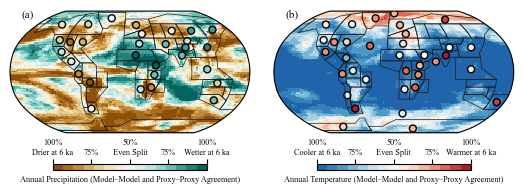

In [10]:
#Plot the figure 7
warnings.filterwarnings('ignore')
plt.figure(figsize=(figSize[0],figSize[1]))
if orient == 'v': gs = gridspec.GridSpec(len(variables),1,hspace=0.1,wspace=0.1)
else:             gs = gridspec.GridSpec(1,len(variables),hspace=0.1,wspace=0.1)
for var in variables:
    #Position figure
    i  = [j for j,x in enumerate(variables) if x == var][0]
    if orient == 'v': ax = plt.subplot(gs[i:(i+1),0:1],projection=ccrs.Robinson())
    else:             ax = plt.subplot(gs[0:1,i:(i+1)],projection=ccrs.Robinson())
    #Set figure colors/labels based on climate Variable 
    if var == 'tas': cramp, units, varname, n = 'RdBu_r','degC', 'Temperature', ['Cooler at 6 ka','Warmer at 6 ka']
    else:            cramp, units, varname, n = 'BrBG', 'mm/day', 'Precipitation', ['Drier at 6 ka','Wetter at 6 ka',]
    #Color bins based on model dimension
    cramp = cmr.get_sub_cmap(cramp,0.1,0.9,N=modelN+1)
    #Set up map
    ax.annotate('('+list(map(chr, range(97, 123)))[i]+')',xy=(0, 0), xycoords='data', xytext=(0.05, 0.95), textcoords='axes fraction', fontsize=8, fontfamily = 'Times New Roman')
    refRegLand.plot_regions(ax=ax,add_label=False,line_kws=dict(linewidth=0.5))
    #Plot data
    model_agree = plt.pcolormesh(modelVals[szn][var]['modelSign%'].lon, modelVals[szn][var]['modelSign%'].lat, modelVals[szn][var]['modelSign%'], 
                                 cmap=cramp, vmin=-100, vmax=100, transform=ccrs.PlateCarree(),alpha=1)
    ax.scatter(proxyData[var].lon, proxyData[var].lat, c=proxyData[var].proxyPct,
               cmap=cramp, s=25 ,ec='k', lw=1, vmin=0, vmax=100, transform=ccrs.PlateCarree())
    #ax.scatter(proxy.longitude, proxy.latitude, s=5 ,ec='red',alpha=1, lw=1, transform=ccrs.PlateCarree())
    #ax.coastlines()
    #Color bar
    if orient == 'v': 
        cbar = plt.colorbar(model_agree,orientation="horizontal",ticks=range(-100,101,50), fraction=0.04, pad=0.15,aspect=25)
        cbar.ax.set_xticklabels(['100%\n'+n[0],'75%','50%\nEven Split','75%','100%\n'+n[1]], fontsize=6, verticalalignment='baseline')
        cbar.ax.xaxis.set_ticks_position("top")    
        cbar.ax.text(0,-400,'Annual '+varname+' (Model–Model and Proxy–Proxy Agreemen)', horizontalalignment='center', verticalalignment='center',fontsize=6)
    else: 
        cbar = plt.colorbar(model_agree,orientation="horizontal",ticks=range(-100,101,50), fraction=0.02, pad=0.1,aspect=25)
        cbar.ax.set_xticklabels(['100%\n'+n[0],'75%','50%\nEven Split','75%','100%\n'+n[1]], fontsize=6, verticalalignment='baseline')
        cbar.ax.xaxis.set_ticks_position("top")    
        cbar.ax.text(0,-400,'Annual '+varname+' (Model–Model and Proxy–Proxy Agreement)', horizontalalignment='center', verticalalignment='center',fontsize=6)
    
#Save/Plot
filename = 'Fig8_midHoloceneAgreement_'
for var in variables: filename=filename+var+'_'
if save: plt.savefig('Figures/Model/'+filename+szn+'.png', dpi=600,format='png', bbox_inches='tight')       
plt.show()


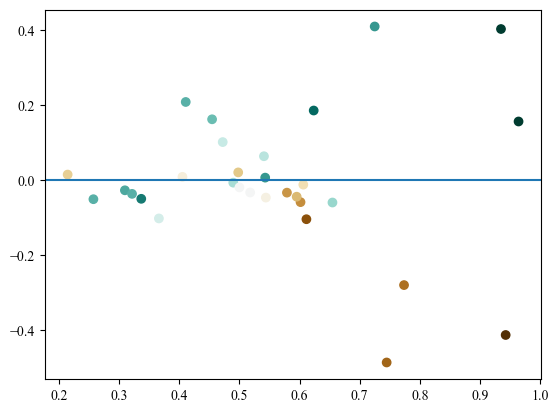

In [7]:
var='pre'
plt.scatter(proxyData[var]['agreeByLoc'],proxyData[var]['PseudoProxyAvg'],
            c=proxyData[var]['proxyPct'],cmap='BrBG',vmin=0,vmax=100)
plt.axhline(0)




In [19]:
#Calculate % warm/cool 6 ka anomalies based on model mean for entire region
for var in variables:
    refReg  = rm.defined_regions.ar6.all
    weights = np.cos(np.deg2rad(modelVals[szn][var]['modelAnom'].lat))
    #Land mask
    mask   = refReg.mask_3D(modelVals[szn][var]['modelAnom'].lon,modelVals[szn][var]['modelAnom'].lat)  
    if var != 'tas':
        land   = rm.defined_regions.natural_earth.land_110
        land   = land.mask_3D(modelVals[szn][var]['modelAnom'].lon,modelVals[szn][var]['modelAnom'].lat)  
        land   = np.array([land.squeeze('region').data]*np.shape(refReg)[0])
        mask = mask*land
    #
    vals_regional = modelVals[szn][var]['modelAnom'].weighted(mask * weights).mean(dim=("lat", "lon",))
    df=pd.DataFrame({'region':vals_regional.abbrevs,
                     'modelN':np.sum(np.sign(vals_regional),axis=0),
                     'anom':vals_regional.mean(axis=0)})
    df['modelPct'] = (100+100*df.modelN/np.max(np.abs(df.modelN)))/2
    #if var == 'tas':
        #print('Number of regions showing consensus for warm 6 ka anomaly')
        #print(str(round(100*52/58)),'%')
        #print(df)#.sort_values('modelPct',ascending=False))#.head(n=5))
    proxyData[var]=proxyData[var].merge(df, left_on='region', right_on='region')

/Users/chrishancock/opt/anaconda3/envs/HC12k/lib/python3.9/site-packages/pygeos/io.py:247: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
/Users/chrishancock/opt/anaconda3/envs/HC12k/lib/python3.9/site-packages/regionmask/defined_regions/_natural_earth.py:471: FutureWarning: ``regionmask.defined_regions.natural_earth`` is deprecated. Please use ``regionmask.defined_regions.natural_earth_v4_1_0`` or ``regionmask.defined_regions.natural_earth_v5_0_0`` instead.
  warnings.warn(
/Users/chrishancock/opt/anaconda3/envs/HC12k/lib/python3.9/site-packages/pygeos/io.py:247: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
/Users/c